In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from timezonefinder import TimezoneFinder
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    mean_absolute_error,
    mean_absolute_percentage_error
)
# also load: _hourly, _monthly, _weekly, _yearly, or _live_daily
from autots import AutoTS, load_daily

In [32]:
from abc import ABC
from abc import abstractmethod

In [33]:
from tqdm import tqdm

# Constants

In [39]:
DATA_PATH = "data/psh_microgrid_total_power.csv"
LATITUDE = 18.852
LONGITUDE = 98.994
TIMEZONE = TimezoneFinder().certain_timezone_at(lat=LATITUDE, lng=LONGITUDE)
TIMESTAMP_COLUMN = "timestamp"
VALUE_COLUMN = "total_power"
FEATURES = [TIMESTAMP_COLUMN, VALUE_COLUMN]
HISTORY_LENGTH = 24
FORECAST_LENGTH = 12

# Utils

In [34]:
class TimeSeriesModel(ABC):
    @abstractmethod
    def forecast(self, history: pd.DataFrame) -> pd.DataFrame:
        ...

In [3]:
def get_history(timeseries: pd.DataFrame, timestamp: pd.Timestamp, hours_n: int) -> pd.DataFrame:
    history = timeseries[timestamp - pd.Timedelta(hours=hours_n) : timestamp - pd.Timedelta(hours=1)]
    if len(history) != hours_n:
        return None
    # print(type(history))
    return history

In [4]:
def get_actual_forecast(timeseries: pd.DataFrame, timestamp: pd.Timestamp, hours_n: int) -> pd.DataFrame:
    actual_forecast = timeseries[timestamp : timestamp  + pd.Timedelta(hours=hours_n-1)]
    if len(actual_forecast) != hours_n:
        return None
    # print(type(actual_forecast))
    return actual_forecast

In [35]:
def simulate_on_timestamp(model: TimeSeriesModel, timeseries: pd.DataFrame, timestamp: pd.Timestamp, history_length, forecast_length):
    history = get_history(timeseries, timestamp, history_length)
    actual = get_actual_forecast(timeseries, timestamp, forecast_length)
    if history is None or actual is None:
        return None
    forecast = model.forecast(history)
    return [history, actual, forecast]

def collect_simulation_on_timestamp_results(simulation_on_timestamp_results):
    [history, actual, forecast] = simulation_on_timestamp_results
    merged_data = pd.merge(history, history, left_index=True, right_index=True)
    merged_data = merged_data.rename(columns={f'{VALUE_COLUMN}_x': 'actual', f'{VALUE_COLUMN}_y': 'model'})
    merged_data["error"] = np.zeros(len(history))
    
    merged_data_next = actual
    merged_data_next = merged_data_next.rename(columns={VALUE_COLUMN: 'actual'})
    merged_data_next["model"] = forecast
    merged_data_next["error"] = merged_data_next["actual"]- merged_data_next["model"]
    
    return pd.concat([merged_data, merged_data_next])

In [67]:
def simulate_on_timeseries(model: TimeSeriesModel, timeseries: pd.DataFrame, history_length, forecast_length):
    timestamps = timeseries.index
    timestamps_realised = []
    errors_on_hours = [[] for _ in range(forecast_length)]
    actuals_on_hours = [[] for _ in range(forecast_length)]
    forecasts_on_hours = [[] for _ in range(forecast_length)]
    RMSE_list = []
    R2_list = []
    R2_list_2 = []
    MAE_list = []
    MAPE_list = []
    SMAPE_list = []
    corr_list = []
    for timestamp in tqdm(timestamps):
        simulation_on_timestamp_results = simulate_on_timestamp(model, timeseries, timestamp, history_length, forecast_length)
        if simulation_on_timestamp_results is None:
            continue
        [history, actual_forecast, forecast] = simulation_on_timestamp_results
        actual_forecast = actual_forecast[VALUE_COLUMN]
        forecast = forecast[VALUE_COLUMN]
        timestamps_realised.append(timestamp)
        for i in range(forecast_length):
            errors_on_hours[i].append(actual_forecast[i] - forecast[i])
            actuals_on_hours[i].append(actual_forecast[i])
            forecasts_on_hours[i].append(forecast[i])
        RMSE_list.append(mean_squared_error(actual_forecast, forecast))
        SS_res = np.sum((actual_forecast - forecast)**2)
        actual_forecast_m = np.ones(len(actual_forecast)) * np.mean(actual_forecast)
        SS_tot = np.sum((actual_forecast - actual_forecast_m)**2)
        R2_list_2.append(1 - ((SS_res) / (SS_tot)))
        R2_list.append(r2_score(actual_forecast, forecast))
        MAE_list.append(mean_absolute_error(actual_forecast, forecast))
        MAPE_list.append(np.mean(np.abs((actual_forecast - forecast) / actual_forecast)))
        SMAPE_list.append(1/len(actual_forecast) * np.sum(2 * np.abs(actual_forecast - forecast) / (np.abs(actual_forecast) + np.abs(forecast))))
        corr_list.append(np.corrcoef(forecast, actual_forecast)[0,1])
    assessment_result_dict = {
            "timestamp": timestamps_realised, 
            "RMSE": RMSE_list,
            "R2": R2_list,
            "R2_2": R2_list_2,
            "MAE": MAE_list,
            "MAPE": MAPE_list,
            "SMAPE": SMAPE_list,
            "corr": corr_list,
        }
    for i in range(forecast_length):
        assessment_result_dict[f"errors_{i}"] = errors_on_hours[i]
        assessment_result_dict[f"actuals_{i}"] = actuals_on_hours[i]
        assessment_result_dict[f"forecasts_{i}"] = forecasts_on_hours[i]
    assessment_result_df = pd.DataFrame(assessment_result_dict)
    return assessment_result_df

In [68]:
def error_scoring(actual: np.ndarray, forecast: np.ndarray) -> dict:
    error = actual - forecast
    ME = np.mean(error)
    MAE = np.mean(np.absolute(error))
    MAPE = np.mean(np.abs((actual - forecast) / actual))
    SMAPE = 1/len(actual) * np.sum(2 * np.abs(actual - forecast) / (np.abs(actual) + np.abs(forecast)))
    # MAPE_2 = mean_absolute_percentage_error(actual, forecast)
    RMSE = np.sqrt(np.dot(error, error) / len(error))
    # RMSE_2 = np.sqrt(np.mean(error**2))
    # RMSE_3 = np.sqrt(mean_squared_error(actual, forecast))
    STD = np.std(error)
    # error_ = error - np.ones(len(error)) * ME
    # STD_2 = np.sqrt(np.mean(error_**2))
    R2 = r2_score(actual, forecast)
    # SS_res = np.sum((actual - forecast)**2)
    # actual_forecast_m = np.ones(len(actual)) * np.mean(actual)
    # SS_tot = np.sum((actual - actual_forecast_m)**2)
    # R2_2 = 1 - ((SS_res) / (SS_tot))
    corr = np.corrcoef(forecast, actual)[0,1]
    return {
    "ME": ME,
    "MAE": MAE,
    "MAPE": MAPE,
    "SMAPE": SMAPE,
    "RMSE": RMSE,
    "STD": STD,
    "R2": R2,
    "corr": corr
}

In [69]:
def collect_metrics(assessment_result_df, forecast_length):
    hours = []
    for i in range(forecast_length):
        hours.append(error_scoring(assessment_result_df[f"actuals_{i}"], assessment_result_df[f"forecasts_{i}"]))
    metrics_df = pd.DataFrame(
            {
        "ME": [hours[i]["ME"] for i in range(forecast_length)],
        "MAE": [hours[i]["MAE"] for i in range(forecast_length)],
        "MAPE": [hours[i]["MAPE"] for i in range(forecast_length)],
        "SMAPE": [hours[i]["SMAPE"] for i in range(forecast_length)],
        "RMSE": [hours[i]["RMSE"] for i in range(forecast_length)],
        "STD": [hours[i]["STD"] for i in range(forecast_length)],
        "R2": [hours[i]["R2"] for i in range(forecast_length)],
        "corr": [hours[i]["corr"] for i in range(forecast_length)]
    }
    )
    return metrics_df

In [5]:
df = pd.read_csv(DATA_PATH, usecols=[TIMESTAMP_COLUMN, VALUE_COLUMN], parse_dates=[TIMESTAMP_COLUMN])

In [6]:
df[TIMESTAMP_COLUMN] = pd.to_datetime(df[TIMESTAMP_COLUMN], utc=False)
df[TIMESTAMP_COLUMN] = df[TIMESTAMP_COLUMN].dt.tz_convert(TIMEZONE)
df = df.sort_values(by=TIMESTAMP_COLUMN)
df = df.set_index(TIMESTAMP_COLUMN)

In [7]:
timestamp_for_split = pd.Timestamp(year=2023, month=5, day=1, tz=TIMEZONE)

In [8]:
df_train = df[:timestamp_for_split]
df_test = df[timestamp_for_split:]

In [9]:
segment = get_actual_forecast(df_test, timestamp_for_split, 7*24)

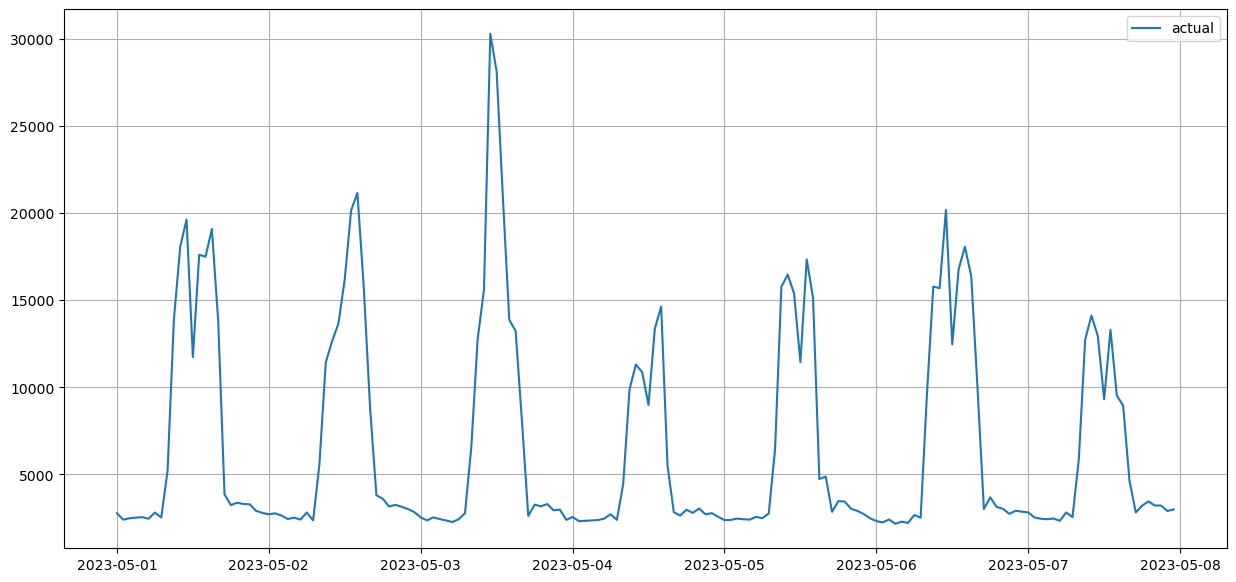

In [10]:
plt.figure(figsize=(15, 7))
# plt.plot(forecast, color="r", label="model")
# plt.axvspan(df.index[-FORECAST_HORIZON], df.index[-1], alpha=0.5, color="lightgrey")
plt.plot(segment, label="actual")
plt.legend()
plt.grid(True)
plt.show()

# autoTS

In [ ]:
# sample datasets can be used in either of the long or wide import shapes
# long = False
# df = load_daily(long=long)

In [13]:
model = AutoTS(
    forecast_length=FORECAST_LENGTH,
    frequency='infer',
    prediction_interval=0.9,
    ensemble='auto',
    model_list="fast",  # "superfast", "default", "fast_parallel"
    transformer_list="fast",  # "superfast",
    drop_most_recent=1,
    max_generations=4,
    num_validations=2,
    validation_method="backwards",
    model_interrupt=True,
)

In [ ]:
model = model.fit(df_train)

In [15]:
prediction = model.predict()

In [62]:
class ModelAutoTS(TimeSeriesModel):
    def __init__(self, model_init):
        self.model_init = model_init
    
    def forecast(self, history: pd.DataFrame) -> pd.DataFrame:
        self.model_init.fit_data(df=history)
        return self.model_init.predict().forecast

In [63]:
model_autoTS_based = ModelAutoTS(model)

In [46]:
timestamp_validation = pd.Timestamp(year=2023, month=7, day=3, hour=10, tz=TIMEZONE)

Data frequency is: H, used frequency is: H


<Axes: xlabel='timestamp'>

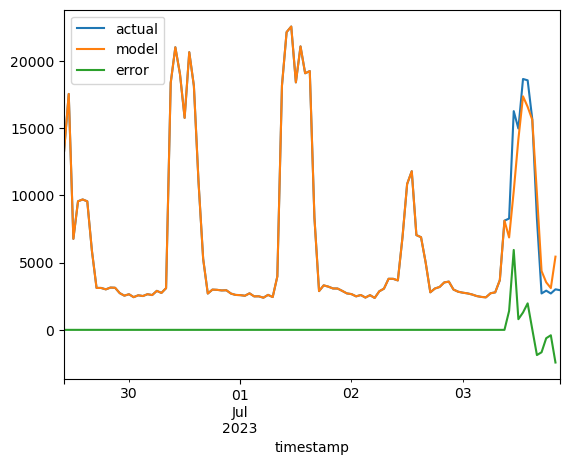

In [64]:
collect_simulation_on_timestamp_results(simulate_on_timestamp(model_autoTS_based, 
                                       df_test, timestamp_validation, HISTORY_LENGTH*4, FORECAST_LENGTH)).plot()

In [ ]:
assessment_result_df = simulate_on_timeseries(model_autoTS_based, df_test, HISTORY_LENGTH*4, FORECAST_LENGTH)

In [71]:
metrics_autoTS_based = collect_metrics(assessment_result_df, FORECAST_LENGTH)

In [72]:
metrics_autoTS_based

,ME,MAE,MAPE,SMAPE,RMSE,STD,R2,corr
0,843.765265,2755.181672,0.430724,0.363601,4780.366329,4705.312149,0.273817,0.546094
1,594.392224,2712.003805,0.432150,0.348467,4761.028420,4723.779154,0.278665,0.550872
2,304.510947,2790.402914,0.473111,0.359419,4764.818296,4755.077967,0.278837,0.555362
3,157.769029,2880.071739,0.501204,0.370425,4859.147202,4856.585268,0.250514,0.540828
4,163.943986,2799.445108,0.483407,0.360411,4789.098644,4786.291696,0.271152,0.557567
5,-21.116187,2828.601665,0.496067,0.362337,4813.520645,4813.474328,0.263327,0.565501
6,-213.315389,2959.954856,0.535948,0.373122,4991.464520,4986.904311,0.208542,0.546026
7,-358.498808,2855.332892,0.531546,0.363447,4837.891161,4824.590085,0.257028,0.588219
8,-239.348699,2909.595284,0.537375,0.372251,4892.169479,4886.310920,0.242032,0.563292
9,-138.020111,2820.276279,0.511940,0.369577,4694.049704,4692.020148,0.303033,0.589411


In [65]:
# plot a sample
# prediction.plot(model.df_wide_numeric,
#                 series=model.df_wide_numeric.columns[0],
#                 start_date="2019-01-01")
# # Print the details of the best model
# print(model)

In [ ]:
# point forecasts dataframe
# forecasts_df = prediction.forecast
# # upper and lower forecasts
# forecasts_up, forecasts_low = prediction.upper_forecast, prediction.lower_forecast

In [ ]:
# accuracy of all tried model results
# model_results = model.results()
# # and aggregated from cross validation
# validation_results = model.results("validation")

In [ ]:
# prediction = model.predict()
# forecasts_df = prediction.forecast
# forecasts_df.reset_index(inplace = True)
# forecasts_df.insert(2, "series_id", forecasts_df.columns.values[1])
# forecasts_df.columns = ['datetime', 'value', 'series_id']